## Noisy oscillator environment: minimal implementation
Based on [Noisy oscillator environment](http://nbviewer.jupyter.org/github/ischurov/TheConsciousnessPrior/blob/master/src/comments/noisy-oscillator-environment.ipynb#Architecture-of-minimal-CP-aware-model).

In [2]:
import tensorflow as tf
import numpy as np

In [354]:
def prepare_network(periods=100):
    x = tf.placeholder(
            tf.float32, (None, periods, 2), name='x')
    # x.shape is (batch_size, periods, 2)
    
    phi = tf.Variable(0., name="phi")
    
    u_c = tf.convert_to_tensor([tf.cos(phi), tf.sin(phi)])
    
    # conscious network
    # c = <u_c, x>
    # c.shape is (batch_size, periods)
    c = tf.einsum('k,itk->it', u_c, x)
    
    # generator is a linear function that has access to c_t and c_{t-1}
    # and tries to predict c_{t+1}
    
    gen_w_current = tf.Variable(1., name="gen_w_current")
    gen_w_previous = tf.Variable(0., name="gen_w_previous")
    hat_a = gen_w_current * c[:, 1:-1] + gen_w_previous * c[:, :-2]
    # hat_a.shape = (batch_size, periods-2)
    
    mse_loss = tf.losses.mean_squared_error(c[:, 2:], hat_a)
    locals_ = locals()
    return {key:locals_[key] for key in ['x', 'phi', 'gen_w_current',
                                         'gen_w_previous', 'mse_loss',
                                         'u_c']}

class NoisyOscillatorEnvironment(object):
    def __init__(self, periods, amplitude=None, phaseshift=None, 
                 frequency=None, noise_amplitude_factor=1, phi=None, 
                 seed=None):
        self.periods = periods
        self.amplitude = amplitude
        self.phaseshift = phaseshift
        self.frequency = frequency
        self.noise_amplitude_factor = noise_amplitude_factor
        self.phi = phi
        self.random = np.random.RandomState()
        if seed:
            self.random.seed(seed)
            
        
    def generate_x(self, batch_size):
        if self.amplitude is None:
            amplitude = self.random.uniform(0, 1, 
                                          size=batch_size)[:, np.newaxis]
        else:
            amplitude = self.amplitude
            
        if self.phaseshift is None:
            phaseshift = self.random.uniform(0, 2 * np.pi, 
                                           size=batch_size)[:, np.newaxis]
        else:
            phaseshift = self.phaseshift
            
        if self.frequency is None:
            frequency = self.random.uniform(0, 1, 
                                          size=batch_size)[:, np.newaxis]
        else:
            frequency = self.frequency
            
        if self.phi is None:
            phi = self.random.uniform(0, 2 * np.pi, size=batch_size)
        else:
            phi = np.repeat(self.phi, batch_size)
        noise_amplitude_factor = self.noise_amplitude_factor

        u_h = np.c_[np.cos(phi), np.sin(phi)]
        u_r = np.c_[np.sin(phi), -np.cos(phi)]
        # shape is (batch_size, 2)

        t = np.arange(self.periods)[np.newaxis, :]
        q = amplitude * np.sin(frequency * (t - phaseshift))
        r = noise_amplitude_factor * amplitude * self.random.uniform(-1, 1, 
                                                                   q.shape)
        
        return (np.einsum('it,ik->itk', q, u_h) + 
                np.einsum('it,ik->itk', r, u_r))

### Visual checking
Let us look at the generated data to check that everything is OK.

In [355]:
import matplotlib.pyplot as plt
%matplotlib inline

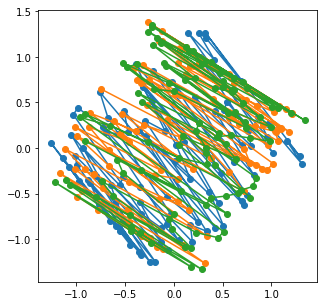

In [359]:
env = NoisyOscillatorEnvironment(periods=100, frequency=0.1, amplitude=1, 
                                 seed=42)
x = env.generate_x(3)
plt.figure(figsize=(5, 5))
for x_ in x:
    plt.plot(x_[:, 0], x_[:, 1], 'o-')

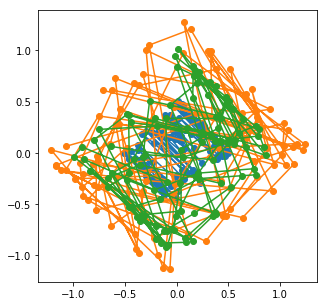

In [362]:
env = NoisyOscillatorEnvironment(periods=100,
                                 phi=np.pi/4, noise_amplitude_factor=1,
                                 seed=42)
x = env.generate_x(3)
plt.figure(figsize=(5, 5))
for x_ in x:
    plt.plot(x_[:, 0], x_[:, 1], 'o-')

### Learning

In [363]:
env = NoisyOscillatorEnvironment(periods=100,
                                 phi=np.pi/6, noise_amplitude_factor=1,
                                 frequency=5,
                                 seed=42)
net = prepare_network(periods=env.periods)
learning_rate = 0.1
optimizer = (tf.train.GradientDescentOptimizer(learning_rate).
             minimize(net['mse_loss']))
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 10
n_batches = 1000

for batch_i in range(n_batches):
    batch_x = env.generate_x(batch_size)
    sess.run(optimizer, feed_dict={net['x']: batch_x})
    if batch_i % (n_batches // 10) == 0:
        print(batch_i, sess.run(net['mse_loss'], feed_dict={net['x']: batch_x}))

0 0.242107
100 0.000834524
200 3.02818e-06
300 2.97754e-08
400 3.15361e-10
500 1.95411e-12
600 1.08664e-13
700 7.48083e-14
800 1.95176e-13
900 1.48838e-13


In [364]:
sess.run(net['phi'], feed_dict={net['x']: batch_x}) - env.phi

-1.0463882615940889e-07

In [365]:
# Looks good

I expected that generator network will learn two-point linear extrapolation:
$$x_{t+1}=2x_t - x_{t-1}$$
But the results can be rather different.

In [366]:
sess.run(net['gen_w_current'], feed_dict={net['x']: batch_x})

0.56732368

In [367]:
sess.run(net['gen_w_previous'], feed_dict={net['x']: batch_x})

-0.99999928